# Denoising Diffusion Probabilistic Models


**Main idea:** Implement a simple diffusion model for generating car images, from scratch, understanding each component in depth.

**Original paper:** https://arxiv.org/pdf/2006.11239.pdf

**Reference tutorials:**
- Diffusion models from scratch in PyTorch by DeepFindr: https://youtu.be/a4Yfz2FxXiY
- Diffusion Models - Live Coding Tutorial 2.0 by dtransposed: https://youtu.be/S_il77Ttrmg?si=aK5rPEXvYd2DFV1X
- Diffusion Models | PyTorch Implementation by Outlier: https://youtu.be/TBCRlnwJtZU?si=GaAdhFN-iGCbauAS

## 1. Getting the dataset


The [original dataset link](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is down, so the download option wasn't working in torchvision. `data = torchvision.datasets.StanfordCars(root="../data/", download=True)` returns an HTTP 404 error.


We can get the dataset from Kaggle instead: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset?resource=download
BUT we need to follow the instructions from this quick fix: https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616

Once we have the right folder structure, this notebook expects the `stanford_cars/` directory to be under the `data/` folder:

```
data/
    stanford_cars/
difussion/
    ddpm.ipynb
```

**NOTES:** 
- Had to download files manually from the sources in that comment first! Make sure the directory structure matches what PyTorch expects.
- OG Pytorch code: https://github.com/pytorch/vision/blob/main/torchvision/datasets/stanford_cars.py

In [59]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

from tqdm import tqdm

In [6]:
train_data = torchvision.datasets.StanfordCars(root="../data/")
test_data = torchvision.datasets.StanfordCars(root="../data/", split="test")

In [7]:
def show_image_samples(dataset, num_samples=20, cols=4):
    """Plots num_samples image samples from the dataset"""
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        

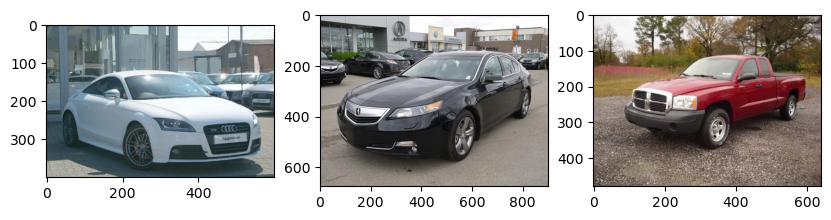

In [8]:
show_image_samples(train_data, num_samples=3, cols=3)

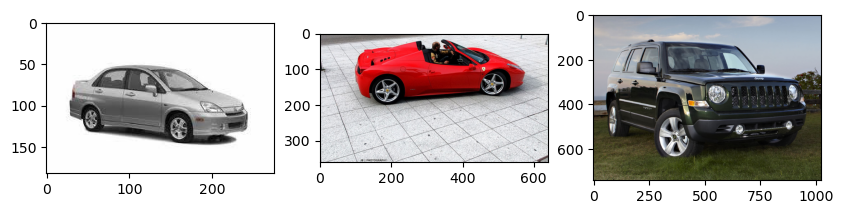

In [9]:
show_image_samples(test_data, num_samples=3, cols=3)

### Data transforms

In [10]:
IMG_SIZE = 64

# PIL -> PyTorch
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), # Scales data into [0, 1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scales between [-1, 1]
])
    
# PyTorch -> PIL
reverse_transforms = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scales from [-1, 1] to [0, 1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # [Channels, Height, Width] to [Height, Width, Channels], which is from PyTorch formatting to NumPy formatting
    transforms.Lambda(lambda t: t * 255.), # Valid PIL image range
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)), # Valid unsigned integer data format
    transforms.ToPILImage(),
])

def load_transformed_dataset(data_transforms):
    train = torchvision.datasets.StanfordCars(root="../data/", transform=data_transforms)
    test = torchvision.datasets.StanfordCars(root="../data/", split="test", transform=data_transforms)
    return torch.utils.data.ConcatDataset([train, test])

### Load the transformed dataset and create a dataloader

In [11]:
BATCH_SIZE = 128
data = load_transformed_dataset(data_transforms)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#### Sample 1 transformed image from the dataset

torch.Size([3, 64, 64])

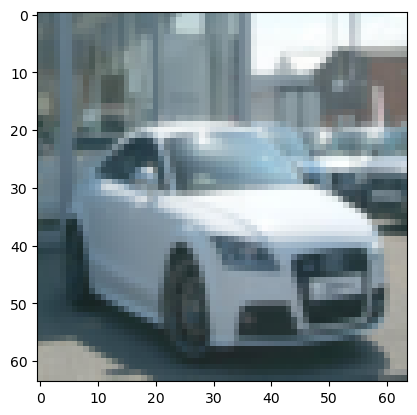

In [12]:
image = data[0][0]
plt.imshow(reverse_transforms(image))
image.shape

## 2. The Forward Process: Adding noise to an image

The forward process of diffusion models consist of a Markov chain that consistently adds Gausian noise to the image based on a variance schedule $\beta_1,...,\beta_T$:

$$q(x_t|x_{t−1}) = N(x_t;\sqrt{1 − \beta_t} x_{t-1}, \beta_t I) $$


This means that the image $x_t$ given the previous image $x_{t-1}$ can be sampled from a Normal distribution with mean $\sqrt{1 − \beta_t} x_{t-1}$ and standard deviation $\beta_t I$

**Let's generate the beta values for each timestep, which represents the variance in the noise that we're creating**

In [13]:
start, end, noise_timesteps = 0.0, 0.9, 20
betas = torch.linspace(start, end, noise_timesteps)
betas[:8], betas.shape

(tensor([0.0000, 0.0474, 0.0947, 0.1421, 0.1895, 0.2368, 0.2842, 0.3316]),
 torch.Size([20]))

**Closed-form Sampling**

A nice property of the forward process is that we can calculate the amount of noise for any arbitrary timestep $t$ with a closed-form equation, which states that the image `x_t` given `x_0` can be drawn from a Normal distribution of mean $\sqrt{\bar{a_t}}x_0$ and standard deviation $(1 - \bar{a_t})$

$$q(x_t | x_0) = N(x_t;\sqrt{\bar{a_t}}x_0, (1 - \bar{a_t})I)$$


The exact value of image $x$ at timestep $t$ is defined by:
$$x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$$

Where $\alpha$ is the complement of $\beta$ or, how much information we're "keeping": $\alpha = 1 - \beta$, and $\epsilon$ is noise coming from a normal distribution with 0 mean and unit variance. 

In [14]:
alphas = 1. - betas
alphas[:8], alphas.shape

(tensor([1.0000, 0.9526, 0.9053, 0.8579, 0.8105, 0.7632, 0.7158, 0.6684]),
 torch.Size([20]))

Then $\bar{a_t}$ is the cumulative product of all $\alpha$ values from timestep $0$ to timestep $t$:

$$\bar{a_t} = \prod_0^{t}{a_t}$$

In [15]:
alpha_hats = torch.cumprod(alphas, axis=0)
alpha_hats[:8], alpha_hats.shape

(tensor([1.0000, 0.9526, 0.8624, 0.7398, 0.5997, 0.4576, 0.3276, 0.2190]),
 torch.Size([20]))

In [17]:
alpha_hats[1]

tensor(0.9526)

Let's try to run a single step of noise addition.

$$x_1 = \sqrt{\bar{\alpha_1}}x_0 + \sqrt{1 - \bar{\alpha_1}} \epsilon$$

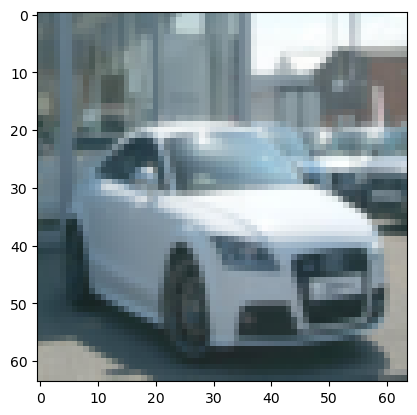

In [30]:
# Original image
plt.imshow(reverse_transforms(x_0))

In [31]:
# Add a single step of noise
x_0 = image
epsilon = torch.randn_like(x_0)
x_1 = (torch.sqrt(alpha_hats[1]) * x_0) + (torch.sqrt(1 - alpha_hats[1]) * epsilon)

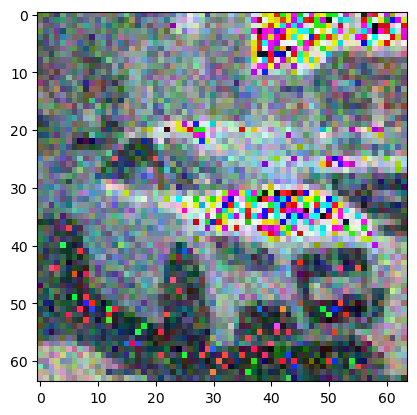

In [32]:
# Noisy image for timestep = 1
plt.imshow(reverse_transforms(x_1))

Nice! now let's write everything into a function:

In [35]:
def forward_diffusion(x_0, t, betas):
    """Calculate the noisy image at timestep t starting from initial image x_0.

    Args:
        x_0: torch.Tensor[batch_size, n_channels, img_size, img_size]
        t: torch.Tensor[batch_size, ]
        betas: torch.Tensor[noise_timesteps, ]

    Returns:
        x_t: torch.Tensor[batch_size, n_channels, img_size, img_size]

    Notes:
        q(x_t | x_0) = N(x_t, \sqrt{\hat{\alpha_t}} * x_0, (1 - \alpha_t) * I)
        x_t = \sqrt{\hat{\alpha_t}} * x_0 + \sqrt{1 - \hat{\alpha_t}} * \epsilon
            where \epsilon ~ N(0, 1)
    """
    
    # Generate random noise with 0 mean and unit variance
    epsilon = torch.randn_like(x_0) 
    alpha_hats = 1 - betas    
    
    # Reshape the alpha_hats[t] to include the other dimensions (batch_size, n_channels, img_size, img_size) and so that we can multiply it by x_0
    alpha_hat = alpha_hats[t].reshape(-1, 1, 1, 1)

    # "New mean" from which we'll the image
    mean = torch.sqrt(alpha_hat) * x_0

    # "New variance" from which we'll sample the image
    variance = torch.sqrt(1 - alpha_hat) * epsilon # std is 1 - alpha_t, so variance is sqrt(1 - alpha_t)

    return mean + variance, epsilon

Here we'll apply noise to a *batch* of images, so we're introducing an extra dimension (the batch dimension) at the beginning, and the result will be of shape `(batch, n_channels, length, width)`

In [36]:
# Timesteps over which to apply noise
t = torch.tensor([0, 1, 2, 3, 4])

# Beta noise scheduler, for now it expects to add noise over a different amount of timesteps 
# so that we can see the effect of adding noise at each timestep t
start, end, noise_timesteps = 0.0, 0.9, 20
betas = torch.linspace(start, end, noise_timesteps)

# Applying noise to the same image over 5 timesteps (to simulate a batch of 5 images)
images = torch.stack([image] * 5)
noisy_images, _ = forward_diffusion(images, t, betas)
noisy_images.shape

torch.Size([5, 3, 64, 64])

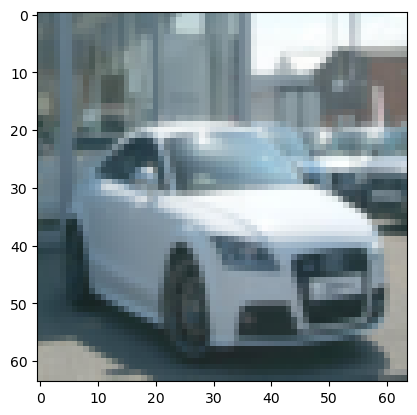

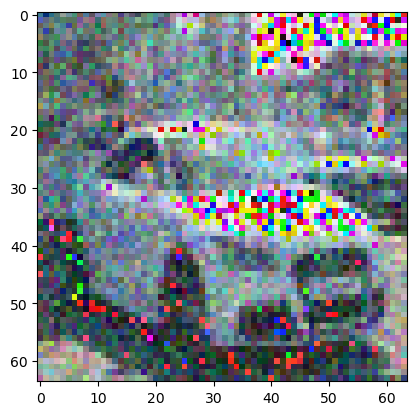

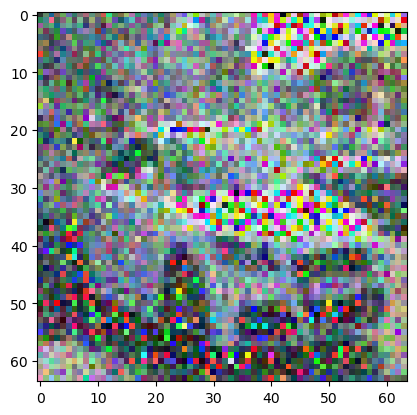

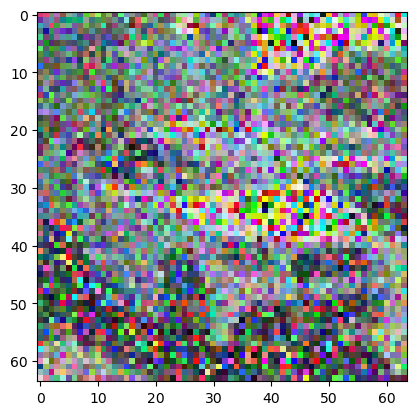

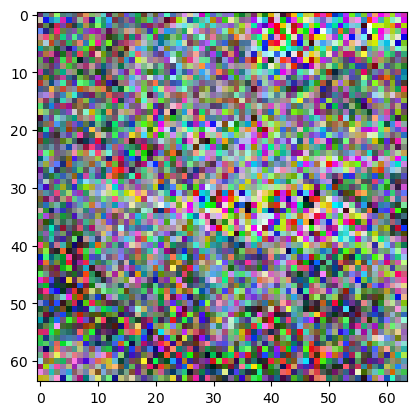

In [37]:
for img in noisy_images: 
    plt.imshow(reverse_transforms(img))
    plt.show()

## 3. The Backward Process: Extracting the noise from a noisy image

# TODO: DO THIS FROM OUTLIER'S TUTORIAL!!!

### The training loop

1. Sample a batch of images from the dataset: $\textbf{x}_0 \sim q(\textbf{x}_0)$
2. Sample a batch of timesteps: $t \sim \text{Uniform}(\{1,...,T\})$
3. Sample a batch of noise: $\epsilon \sim \mathcal{N}(\textbf{0, I})$
4. GRADIENT DESCENT


The model that actually does the learning is a UNet architecture:

#### U-Net

In [40]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [45]:
model = UNet()
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 62714307


In [60]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def sample_timesteps(n_timesteps):
    pass

def sample_images(n_images):
    pass

def train():
    for epoch in range(NUM_EPOCHS):
        for i, (images, _) in enumerate(tqdm(dataloader)):
            t = sample_timesteps(images.shape[0])
            x_t, noise = forward_diffusion(images, t, betas)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

#### Sampling

TODO: Copy algorithm

In [56]:
betas, betas[[0, 2]], betas.gather(-1, torch.tensor([0, 2]))

(tensor([0.0000, 0.0474, 0.0947, 0.1421, 0.1895, 0.2368, 0.2842, 0.3316, 0.3789,
         0.4263, 0.4737, 0.5211, 0.5684, 0.6158, 0.6632, 0.7105, 0.7579, 0.8053,
         0.8526, 0.9000]),
 tensor([0.0000, 0.0947]),
 tensor([0.0000, 0.0947]))

In [ ]:
@torch.no_grad()
def sample_timestep(x, t, betas):
    betas_t = betas[t]
    pass

@torch.no_grad()
def sample_plot_image():
    pass